# Comparison of results to galaxy morphology

This notebook tests possible links between the pitch angles recovered from our hierarchical Bayesian model and measures of mass and morphology, including

- Total stellar mass, measured by Mendel et al. (2014)
- Bulge size, measured using Galaxy Zoo 2 data and the method described by Masters et al. (2019)
$$B_\mathrm{avg} = 0.2 \times p_\mathrm{just\ noticeable} + 0.8 \times p_\mathrm{obvious} + 1.0 \times p_\mathrm{dominant}$$
- Bar fraction, using Galaxy Zoo 2's "bar fraction" $p_\mathrm{bar}$, and the proposed limits for "no bar" and "strongly barred" from Masters et al. (2012) and Skibba et al. (2012)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import numpy as np
import pandas as pd
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.text import Annotation
from matplotlib import rc
import seaborn as sns
from scipy.optimize import minimize
import pymc3 as pm
from tqdm import tqdm
import scipy.stats as st
import corner
import warnings
from IPython.display import Latex
from gzbuilder_analysis import load_aggregation_results, load_fit_results
from hierarchial_model import UniformBHSM, plot_galaxy
warnings.simplefilter('ignore', UserWarning)

Load in the results from *Galaxy Builder*

In [3]:
agg_results = load_aggregation_results('lib/aggregation_results')

In [4]:
fit_results = load_fit_results('lib/tuning_results')

Load in the output of the MCMC model

In [5]:
BHSM_OUTPUT_FILE = 'n129d1000t500.pickle'

In [6]:
res = UniformBHSM.load(BHSM_OUTPUT_FILE)
bhsm = res['bhsm']
trace = res['trace']

In [7]:
res.keys()

dict_keys(['galaxies', 'n_chains', 'bhsm', 'trace'])

In [8]:
display(bhsm.model)

We'll also load some extra metadata on galaxy subjects

In [9]:
gz2_spiral_data = pd.read_csv('lib/gz2_spiral_data.csv', index_col=0)

hart_catalog = pd.read_csv('lib/hart_psi_table.csv', index_col=0)
subject_metadata = pd.read_csv('lib/galaxy-builder-subjects.csv', index_col=0).metadata.apply(json.loads).apply(pd.Series)

dr7objid_map = subject_metadata['SDSS dr7 id']\
    .rename('dr7objid')\
    .dropna()\
    .astype(np.int64)\
    .drop_duplicates()\
    .reset_index()\
    .set_index('dr7objid')\
    .reindex(hart_catalog.index)\
    .dropna()

hart_catalog = hart_catalog.assign(subject_id=dr7objid_map).dropna().reset_index().set_index('subject_id').replace(-999, np.nan)

In [10]:
gal_pa_samples = pd.DataFrame(
    trace['phi_gal'].T,
    index=bhsm.galaxies.index
)
pa_expectation = gal_pa_samples.mean(axis=1)
pa_std = gal_pa_samples.std(axis=1)

print('N Galaxies:', len(bhsm.galaxies))
print('N Arms:    ', bhsm.n_arms)
print('N Points:  ', bhsm.data.shape[0])

N Galaxies: 129
N Arms:     247
N Points:   238433


## Mass comparison

Does stellar mass play a role in spiral arm evolution?

In [11]:
n_arm_map = pd.Series(bhsm.gal_n_arms, index=bhsm.galaxies.index)

arm_pa_samples = pd.DataFrame(trace['phi_arm'].T, index=pd.MultiIndex.from_tuples([
    (i, j)
    for i in gal_pa_samples.index
    for j in range(n_arm_map.loc[i])
]))
arm_mean_pas = arm_pa_samples.mean(axis=1)

In [12]:
pa_samples = gal_pa_samples.T.sample(500).unstack()

In [13]:
reindex_masses = hart_catalog.logMstar.reindex(pa_samples.index.get_level_values(0))
reindex_masses.index = pa_samples.index

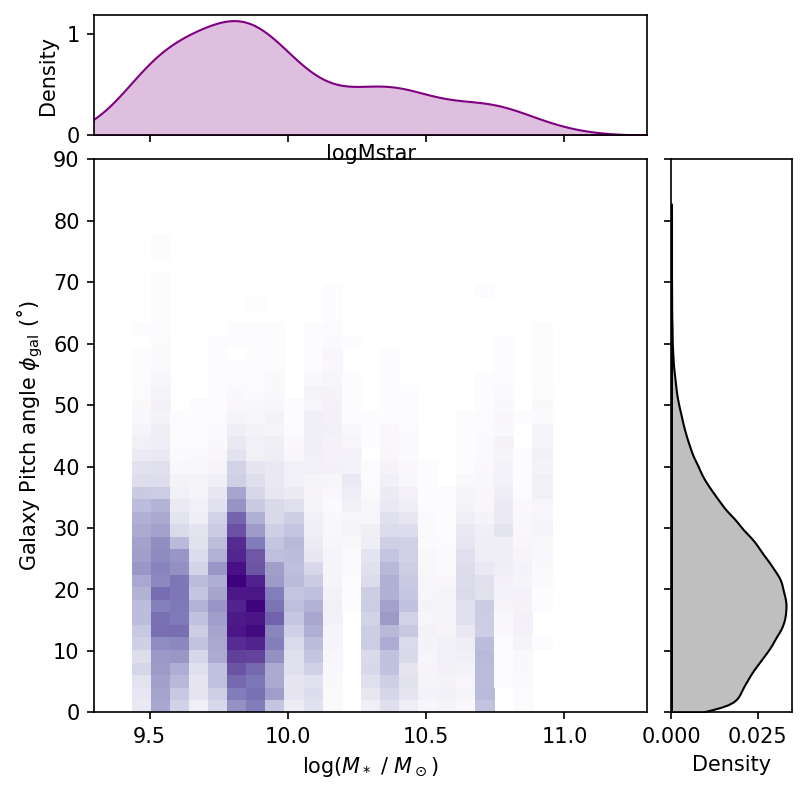

In [15]:
fig = plt.figure(figsize=(5*1.2, 5*1.2), dpi=150)
gs = GridSpec(5, 5, figure=fig)
ax_ms_hx = fig.add_subplot(gs[1:5, 0:4])
ax_ms_kd = fig.add_subplot(gs[0, 0:4], sharex=ax_ms_hx)
ax_pa_kd = fig.add_subplot(gs[1:5, 4:5], sharey=ax_ms_hx)

sampled_df = pd.concat((
    pa_samples.rename('phi'),
    reindex_masses,
), axis=1)
bx = np.linspace(9.3, 11.3, 30)
by = np.linspace(0, 90, 45)
ax_ms_hx.hist2d(*sampled_df[['logMstar', 'phi']].dropna().values.T, cmap='Purples', cmin=0.001, bins=(bx, by))
ax_ms_hx.set_xticks([9, 9.5, 10, 10.5, 11, 11.5])
ax_ms_hx.set_xlim(bx.min(), bx.max())
sns.kdeplot(hart_catalog.logMstar.dropna(), ax=ax_ms_kd, color='purple', label='', shade=True, bw_method='scott')
sns.kdeplot(x=None, y=gal_pa_samples.unstack(), ax=ax_pa_kd, color='k', shade=True, clip=(0, 90), bw_method='scott')
plt.setp([
    ax_pa_kd.get_yticklabels(),
    ax_ms_kd.get_xticklabels(),
], visible=False);
plt.subplots_adjust(top=0.9)
# plt.suptitle('Comparison of pitch angle to Stellar Mass');
ax_ms_hx.set_xlabel(r'$\log(M_*\ /\ M_\odot)$')
ax_ms_hx.set_ylabel(r'Galaxy Pitch angle $\phi_\mathrm{gal}$ (˚)')
plt.savefig('plots/stellar_mass_phigal_distribution.jpg', bbox_inches='tight')
plt.savefig('plots/stellar_mass_phigal_distribution.pdf', bbox_inches='tight')
del sampled_df

## Morphology comparison

Does pitch angle vary with bulge or bar strength?

In [16]:
from astropy.io import fits
meta = pd.read_csv('lib/gal-metadata.csv', index_col=0)
gz_table = fits.open('../source_files/NSA_GalaxyZoo.fits')
gz_k = {k: gz_table[1].data[k] for k in gz_table[1].data.dtype.names}
gz_df = pd.DataFrame({k: v for k, v in gz_k.items() if type(v[0]) != np.ndarray}, dtype=object).set_index('dr7objid')

In [17]:
subject_metadata = (
    pd.read_csv('lib/galaxy-builder-subjects.csv', index_col=0)
    .metadata
    .apply(lambda s: pd.Series(json.loads(s)))
)

gz2_data = (
    subject_metadata[['SDSS dr7 id']]
        .drop_duplicates()
        .reindex(bhsm.galaxies.index)
        .reset_index()
        .rename(columns=dict(index='subject_id'))
        .dropna() # remove galaxies without SDSS DS7 IDs (early test galaxies)
        .astype('int64')
        # do the merge (could just use join)
        .merge(gz_df, how='right', left_on='SDSS dr7 id', right_index=True)
        .dropna() # get rid of galaxies which didn't match
        .set_index('subject_id')
)

Pick a value of $B_\mathrm{avg}$ to split our sample at:

In [18]:
BULGE_SPLIT_POINT = 0.28

In [19]:
morphology_comparison = pd.concat((
    gz2_data.t03_bar_a06_bar_fraction.rename('bar_fraction').astype(float),
    gz2_data.t05_bulge_prominence_a10_no_bulge_fraction.rename('no_bulge_fraction').astype(float),
    gz2_data.t05_bulge_prominence_a11_just_noticeable_fraction.rename('just_noticeable_bulge_fraction').astype(float),
    gz2_data.t05_bulge_prominence_a12_obvious_fraction.rename('obvious_bulge_fraction').astype(float),
    gz2_data.t05_bulge_prominence_a13_dominant_fraction.rename('dominant_bulge_fraction').astype(float),
    pa_expectation.rename('phi'),
    fit_results.bulge_frac.rename('bar_to_total'),
    fit_results.bar_frac.rename('bulge_to_total'),
    pa_std.rename('sd'),
    bhsm.galaxies.apply(len).rename('n'),
), axis=1).dropna()

# derived quantities
morphology_comparison.eval('no_bar = bar_fraction < 0.2', inplace=True)
morphology_comparison.eval('strongly_barred = bar_fraction > 0.5', inplace=True)
morphology_comparison.eval(
    'bulge_strength = \
        0.2 * just_noticeable_bulge_fraction \
        + 0.8 * obvious_bulge_fraction \
        + 1.0 * dominant_bulge_fraction\
    ',
    inplace=True
)
morphology_comparison.eval('bulge_dominated = bulge_strength > @BULGE_SPLIT_POINT', inplace=True)
morphology_comparison.eval('central_to_total = bulge_to_total + bar_to_total', inplace=True)

Percent bulge dominated = 38%
Percent strongly barred = 26%
Percent without bar = 39%


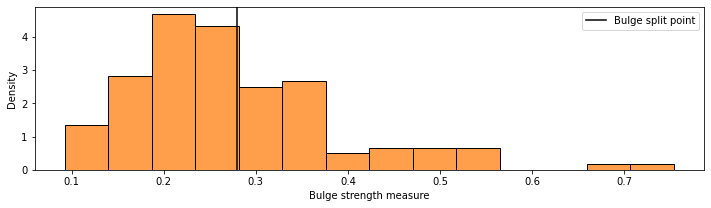

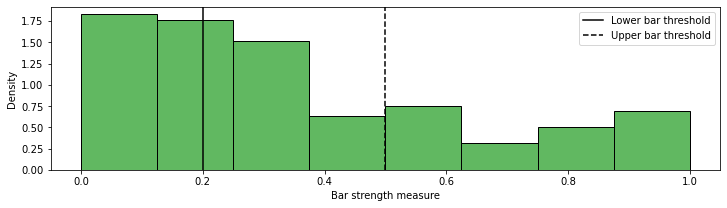

In [20]:
plt.figure(figsize=(12, 3))
sns.histplot(morphology_comparison.bulge_strength, color='C1', stat='density')
plt.axvline(BULGE_SPLIT_POINT, c='k', label='Bulge split point')
plt.xlabel('Bulge strength measure')
plt.legend();

plt.figure(figsize=(12, 3))
sns.histplot(morphology_comparison.bar_fraction, color='C2', stat='density')
plt.axvline(0.2, c='k', label='Lower bar threshold')
plt.axvline(0.5, c='k', ls='--', label='Upper bar threshold')
plt.xlabel('Bar strength measure')
plt.legend();

print('Percent bulge dominated = {:.0%}'.format(
    morphology_comparison.bulge_dominated.sum() / len(morphology_comparison.bulge_dominated)
))
print('Percent strongly barred = {:.0%}'.format(
    morphology_comparison.strongly_barred.sum() / len(morphology_comparison.strongly_barred)
))
print('Percent without bar = {:.0%}'.format(
    morphology_comparison.no_bar.sum() / len(morphology_comparison.no_bar)
))

In [21]:
print('Percent bulge dominated = {:.0%}'.format(
    morphology_comparison.bulge_dominated.sum() / len(morphology_comparison.bulge_dominated)
))
print('Percent strongly barred = {:.0%}'.format(
    morphology_comparison.strongly_barred.sum() / len(morphology_comparison.strongly_barred)
))
print('Percent without bar = {:.0%}'.format(
    morphology_comparison.no_bar.sum() / len(morphology_comparison.no_bar)
))

Percent bulge dominated = 38%
Percent strongly barred = 26%
Percent without bar = 39%


In [22]:
n_bulge_dominated = morphology_comparison.bulge_dominated.sum()
n_disc_dominated = (~morphology_comparison.bulge_dominated).sum()
n_strong_bar = morphology_comparison.strongly_barred.sum()
n_no_bar = morphology_comparison.no_bar.sum()

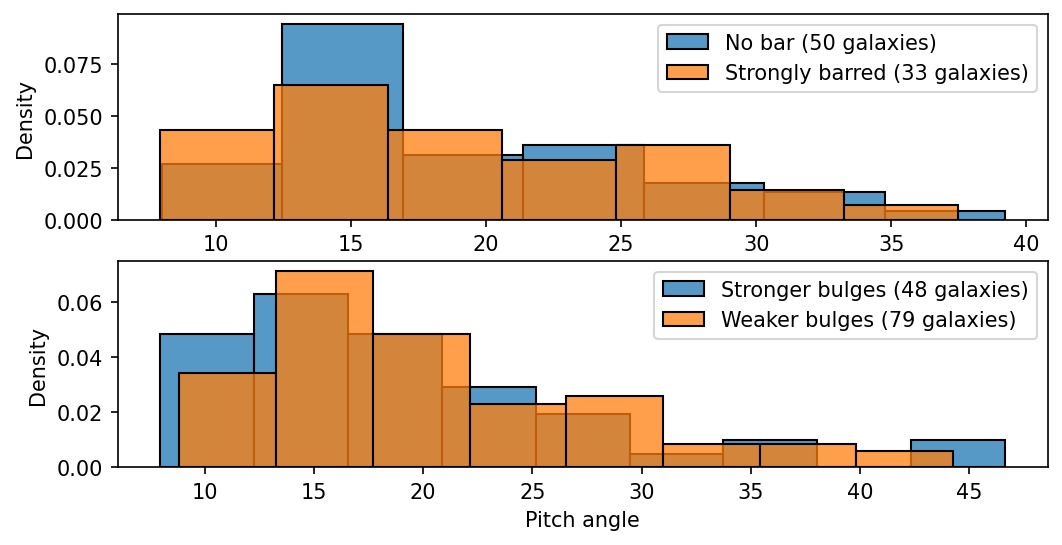

In [23]:
plt.figure(figsize=(8, 4), dpi=150)
plt.subplot(211)
sns.histplot(
    morphology_comparison['phi'][morphology_comparison['no_bar']].rename('No bar'),
    label=f'No bar ({n_no_bar} galaxies)',
    color='C0',
    stat='density',
)
sns.histplot(
    morphology_comparison['phi'][morphology_comparison['strongly_barred']].rename('Bar'),
    label=f'Strongly barred ({n_strong_bar} galaxies)',
    color='C1',
    stat='density',
)
plt.xlabel('Pitch angle')
plt.legend()

plt.subplot(212)
sns.histplot(
    morphology_comparison['phi'][
        morphology_comparison['bulge_dominated']
    ],
    label=f'Stronger bulges ({n_bulge_dominated} galaxies)',
    color='C0',
    stat='density',
)
sns.histplot(
    morphology_comparison['phi'][
        np.logical_not(morphology_comparison['bulge_dominated'])
    ],
    label=f'Weaker bulges ({n_disc_dominated} galaxies)',
    color='C1',
    stat='density',
)
plt.xlabel('Pitch angle')
plt.legend()

The correlation matrix below shows very weak links between morphology and pitch angle, as does the density plot from the trace

In [24]:
display(st.pearsonr(morphology_comparison.phi, morphology_comparison.bulge_strength))
display(st.pearsonr(morphology_comparison.phi, morphology_comparison.bar_fraction))

(-0.018526627177278335, 0.8362145624184216)

(-0.04977484855034816, 0.5783937077629596)

In [25]:
def set_color_by_correlation(row, cmap=cm.get_cmap('RdYlGn', 12)):
    values = (np.array([cmap((value + 1) / 2) for value in row])  * [256, 256, 256, 1]).astype(int)
    return [f'background-color: rgba{tuple(value.tolist())}' for value in values]

In [26]:
subset = morphology_comparison.drop(
    columns=['no_bar', 'strongly_barred', 'bulge_dominated']
)
corr_df = pd.concat((
    subset.corr(method='pearson').loc[['phi', 'sd', 'n']].T.add_suffix('_pearson'),
    subset.corr(method='spearman').loc[['phi', 'sd', 'n']].T.add_suffix('_spearman'),
    subset.corr(method='kendall').loc[['phi', 'sd', 'n']].T.add_suffix('_kendall'),
), axis=1).sort_index(axis=1)
corr_df.columns = pd.MultiIndex.from_tuples([c.split('_') for c in corr_df.columns])
corr_df.style.apply(set_color_by_correlation)

We can see a similar lack of correlation using density plots (which encompasses the whole trace rather than just the expectation)

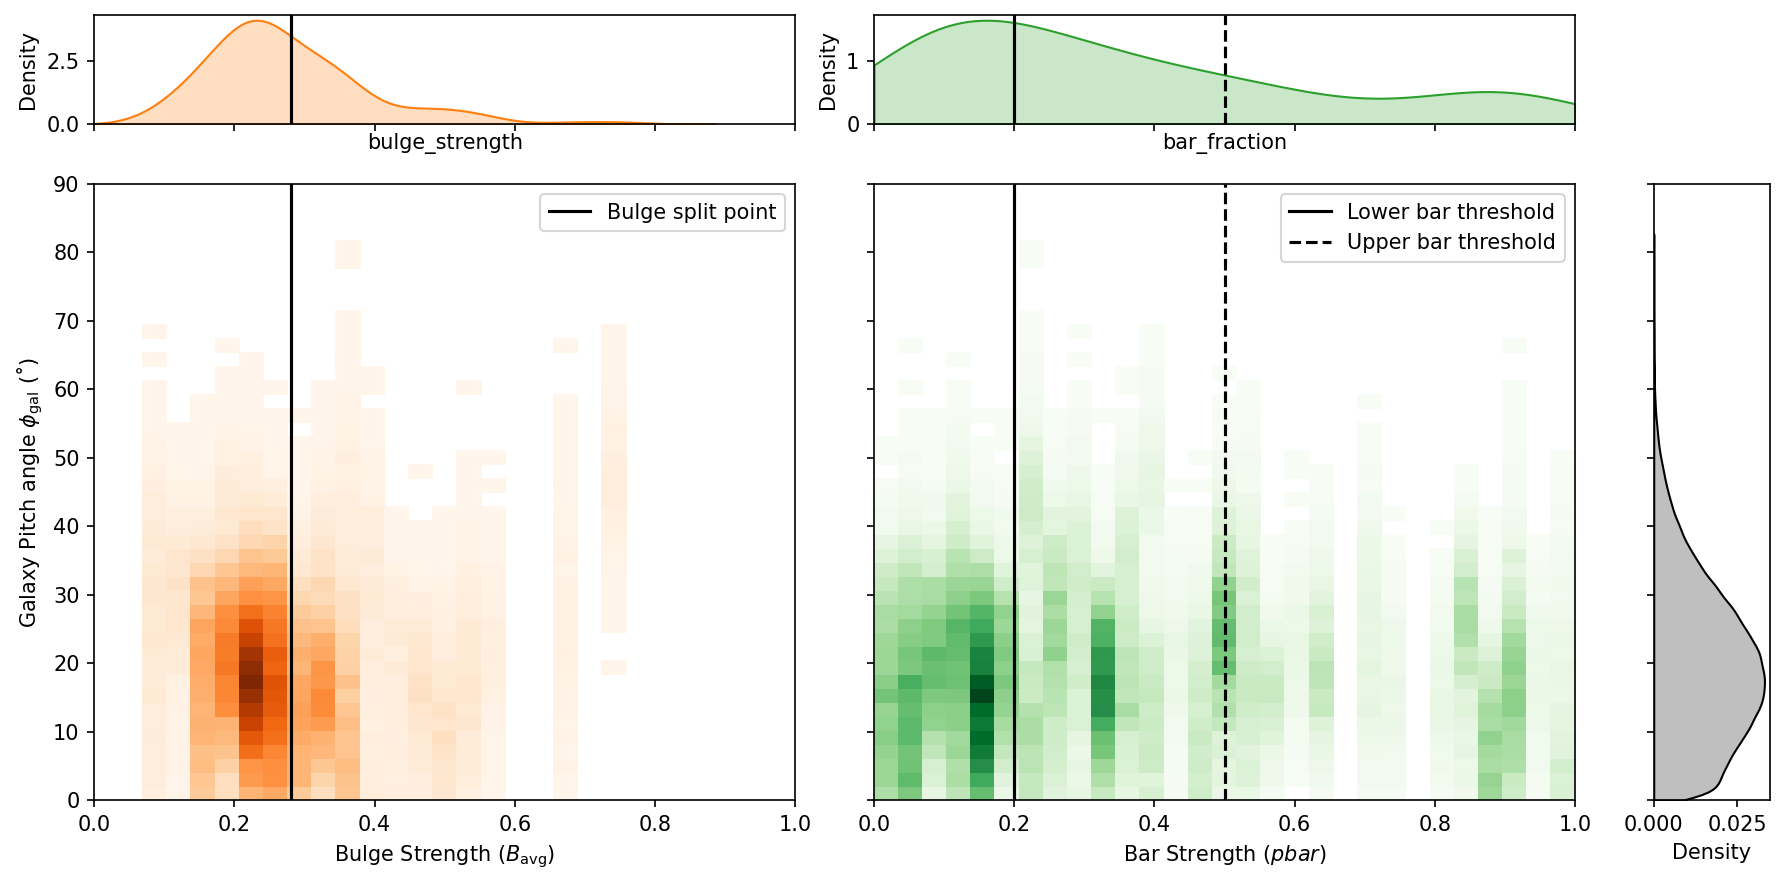

In [27]:
rc('text', usetex=False)

pa_samples = gal_pa_samples.T.sample(500).unstack()

reindex_bulge_fractions = morphology_comparison['bulge_strength'].reindex(pa_samples.index.get_level_values(0))
reindex_bulge_fractions.index = pa_samples.index

reindex_bar_fractions = morphology_comparison['bar_fraction'].reindex(pa_samples.index.get_level_values(0))
reindex_bar_fractions.index = pa_samples.index

sampled_df = pd.concat((
    pa_samples.rename('phi'),
    reindex_bar_fractions,
    reindex_bulge_fractions,
), axis=1)


fig = plt.figure(figsize=(10*1.2, 5*1.2), dpi=150)
gs = GridSpec(5, 9, figure=fig)
ax_bg_hx = fig.add_subplot(gs[1:5, 0:4])
ax_bg_kd = fig.add_subplot(gs[0, 0:4], sharex=ax_bg_hx)
ax_br_hx = fig.add_subplot(gs[1:5, 4:8], sharex=ax_bg_hx, sharey=ax_bg_hx)
ax_br_kd = fig.add_subplot(gs[0:1, 4:8], sharex=ax_br_hx)
ax_pa_kd = fig.add_subplot(gs[1:5, 8:9], sharey=ax_bg_hx)

bx = np.linspace(0, 1, 30)
by = np.linspace(0, 90, 45)
ax_bg_hx.hist2d(*sampled_df[['bulge_strength', 'phi']].dropna().values.T, cmap='Oranges', cmin=0.001, bins=(bx, by))
ax_bg_hx.set_xlim(0, 1)
sns.kdeplot(morphology_comparison['bulge_strength'], ax=ax_bg_kd, color='C1', label='', shade=True, clip=(0, 1), bw_method='scott')

ax_br_hx.hist2d(*sampled_df[['bar_fraction', 'phi']].dropna().values.T, cmap='Greens', cmin=0.001, bins=(bx, by))
sns.kdeplot(morphology_comparison['bar_fraction'], ax=ax_br_kd, color='C2', label='', shade=True, clip=(0, 1), bw_method='scott')

sns.kdeplot(y=gal_pa_samples.unstack(), ax=ax_pa_kd, color='k', shade=True, clip=(0, 90), bw_method='scott')

plt.sca(ax_bg_hx)
plt.axvline(BULGE_SPLIT_POINT, c='k', label='Bulge split point')
plt.legend()
plt.sca(ax_bg_kd)
plt.axvline(BULGE_SPLIT_POINT, c='k', label='Bulge split point')
plt.sca(ax_br_hx)
plt.axvline(0.2, c='k', label='Lower bar threshold')
plt.axvline(0.5, c='k', ls='--', label='Upper bar threshold')
plt.legend()
plt.sca(ax_br_kd)
plt.axvline(0.2, c='k', label='Lower bar threshold')
plt.axvline(0.5, c='k', ls='--', label='Upper bar threshold')

plt.setp([
    ax_br_hx.get_yticklabels(),
    ax_pa_kd.get_yticklabels(),
    ax_bg_kd.get_xticklabels(),
    ax_br_kd.get_xticklabels(),
], visible=False)

ax_bg_hx.set_xlabel(r'Bulge Strength ($B_\mathrm{avg}$)')
ax_bg_hx.set_ylabel(r'Galaxy Pitch angle $\phi_\mathrm{gal}$ (˚)')
ax_br_hx.set_xlabel(r'Bar Strength ($\it{pbar}$)')
# ax_bg_kd.set_title('Bulge Strength', dict(fontsize=20))
# ax_br_kd.set_title('Bar Fraction', dict(fontsize=20))
plt.tight_layout()
plt.savefig('plots/bulge_bar_phigal_distribution.jpg', bbox_inches='tight')
plt.savefig('plots/bulge_bar_phigal_distribution.pdf', bbox_inches='tight')
del reindex_bulge_fractions
del reindex_bar_fractions
del sampled_df

We'll do more marginalized Anderson-Darling tests to determine if the pitch angles of galaxies with our morphological selections are drawn from different distributions (null hypothesis being that they are drawn from the same distribution).

We'll also test for a difference with respect to arms:

In [28]:
arm_morphology_comparison = morphology_comparison.reindex(bhsm.galaxies.index[bhsm.gal_arm_map])
arm_morphology_comparison.index = pd.MultiIndex.from_tuples([
    (bhsm.galaxies.index[i], arm_idx)
    for i in range(len(bhsm.galaxies.index))
    for arm_idx in range(bhsm.gal_n_arms.iloc[i])
], names=('subject_id', 'arm_index'))

arm_morphology_comparison.dropna(inplace=True)

arm_pa_samples_ = arm_pa_samples.reindex(arm_morphology_comparison.index)

In [29]:
arm_subset = arm_morphology_comparison.drop(columns=['no_bar', 'strongly_barred', 'bulge_dominated'])\
    .assign(phi_arm=arm_pa_samples_.mean(axis=1), phi_arm_sd=arm_pa_samples_.std(axis=1))
arm_corr_df = pd.concat((
    arm_subset.corr(method='pearson').loc[['phi_arm', 'phi_arm_sd']].T.add_suffix('-pearson'),
    arm_subset.corr(method='spearman').loc[['phi_arm', 'phi_arm_sd']].T.add_suffix('-spearman'),
    arm_subset.corr(method='kendall').loc[['phi_arm', 'phi_arm_sd']].T.add_suffix('-kendall'),
), axis=1).sort_index(axis=1)
arm_corr_df.columns = pd.MultiIndex.from_tuples([c.split('-') for c in arm_corr_df.columns])
arm_corr_df.style.apply(set_color_by_correlation)

In [30]:
anderson_bulge = pd.Series([], name='anderson_test_result', dtype=object)
anderson_bar = pd.Series([], name='anderson_test_result', dtype=object)

with tqdm(gal_pa_samples.reindex(morphology_comparison.index).T.iterrows(), total=gal_pa_samples.shape[1]) as bar:
    for i, phi_gal_est in bar:
        anderson_bar[i] = st.anderson_ksamp((
            phi_gal_est[morphology_comparison['no_bar']].rename('No bar'),
            phi_gal_est[~(
                morphology_comparison['no_bar'].astype(bool)
                | morphology_comparison['strongly_barred'].astype(bool)
            )],
            phi_gal_est[morphology_comparison['strongly_barred']].rename('Bar'),
        ))
        anderson_bulge[i] = st.anderson_ksamp((
            phi_gal_est[morphology_comparison['bulge_dominated']],
            phi_gal_est[~morphology_comparison['bulge_dominated']]
        ))

anderson_bulge = anderson_bulge.apply(pd.Series).rename(columns={0: 'value', 1: 'levels', 2: 'significance'})
anderson_bar = anderson_bar.apply(pd.Series).rename(columns={0: 'value', 1: 'levels', 2: 'significance'})

arm_anderson_bulge = pd.Series([], name='anderson_test_result', dtype=object)
arm_anderson_bar = pd.Series([], name='anderson_test_result', dtype=object)

with tqdm(arm_pa_samples_.T.iterrows(), total=arm_pa_samples_.shape[1]) as bar:
    for i, phi_arm_est in bar:
        arm_anderson_bar[i] = st.anderson_ksamp((
            # no bar
            phi_arm_est[arm_morphology_comparison['no_bar']],
            # weak bar
            phi_arm_est[~(
                arm_morphology_comparison['no_bar'].astype(bool)
                | arm_morphology_comparison['strongly_barred'].astype(bool)
            )],
            # strong bar
            phi_arm_est[arm_morphology_comparison['strongly_barred']],
        ))
        arm_anderson_bulge[i] = st.anderson_ksamp((
            phi_arm_est[arm_morphology_comparison['bulge_dominated']],
            phi_arm_est[~arm_morphology_comparison['bulge_dominated'].astype(bool)]
        ))

arm_anderson_bulge = arm_anderson_bulge.apply(pd.Series).rename(columns={0: 'value', 1: 'levels', 2: 'significance'})
arm_anderson_bar = arm_anderson_bar.apply(pd.Series).rename(columns={0: 'value', 1: 'levels', 2: 'significance'})

100%|██████████| 2000/2000 [00:09<00:00, 217.43it/s]


Bulge strength Thresholds:
       25%: 0.33, reject 34% (100%) of the time
       10%: 1.23, reject 14% (80%) of the time
        5%: 1.96, reject 7% (2%) of the time
      2.5%: 2.72, reject 3% (0%) of the time
        1%: 3.75, reject 1% (0%) of the time
      0.5%: 4.59, reject 1% (0%) of the time
      0.1%: 6.55, reject 0% (0%) of the time
Bar strength Thresholds:
       25%: 0.45, reject 34% (32%) of the time
       10%: 1.31, reject 12% (0%) of the time
        5%: 1.94, reject 6% (0%) of the time
      2.5%: 2.58, reject 3% (0%) of the time
        1%: 3.42, reject 1% (0%) of the time
      0.5%: 4.07, reject 0% (0%) of the time
      0.1%: 5.56, reject 0% (0%) of the time


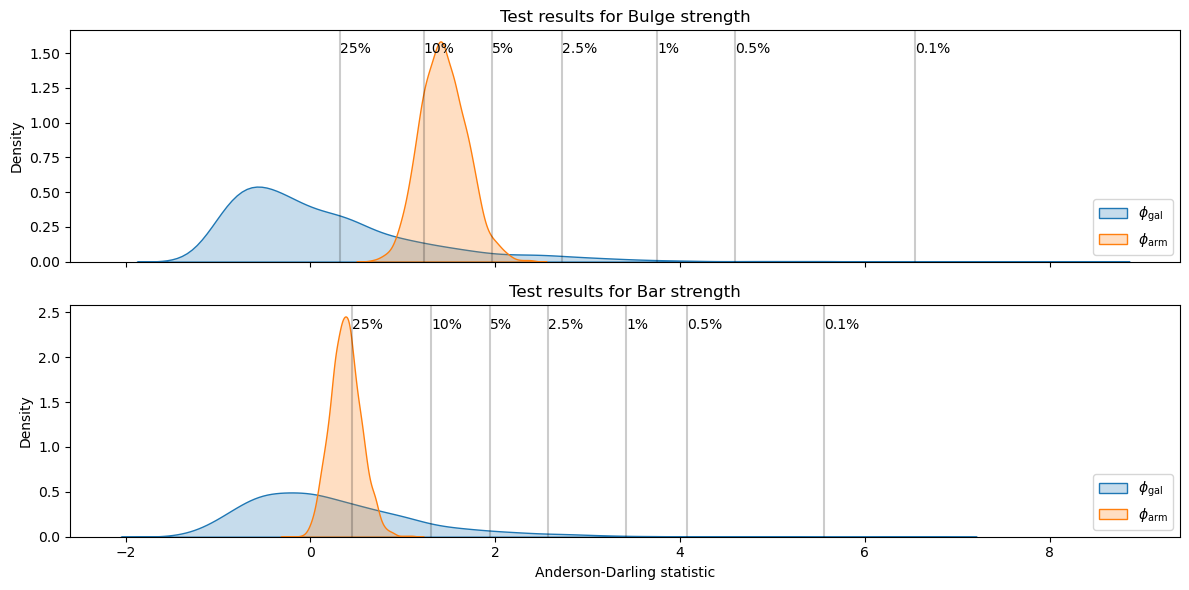

In [31]:
f, ax = plt.subplots(nrows=2, figsize=(12, 6), sharex=True, dpi=100)
plt.sca(ax[0])
plt.title('Test results for Bulge strength')
sns.kdeplot(anderson_bulge['value'], label=r'$\phi_\mathrm{gal}$', shade=True)
sns.kdeplot(arm_anderson_bulge['value'], label=r'$\phi_\mathrm{arm}$', shade=True)
print('Bulge strength Thresholds:')
for i, j in zip(
    ('25%', '10%', '5%', '2.5%', '1%', '0.5%', '0.1%'),
    np.stack(anderson_bulge['levels'].values).mean(axis=0),
):
    freq = (anderson_bulge['value'] >= j).sum() / len(anderson_bulge['value'])
    freq_arm = (arm_anderson_bulge['value'] >= j).sum() / len(arm_anderson_bulge['value'])
    print(f'{i: >10}: {j:.2f}, reject {freq:.0%} ({freq_arm:.0%}) of the time')
    plt.axvline(j, color='k', alpha=0.2)
    plt.text(j, plt.ylim()[1]*0.9, i)
plt.legend(loc='lower right')
plt.sca(ax[1])
plt.title('Test results for Bar strength')
sns.kdeplot(anderson_bar['value'], label=r'$\phi_\mathrm{gal}$', shade=True)
sns.kdeplot(arm_anderson_bar['value'], label=r'$\phi_\mathrm{arm}$', shade=True)
print('Bar strength Thresholds:')
for i, j in zip(
    ('25%', '10%', '5%', '2.5%', '1%', '0.5%', '0.1%'),
    np.stack(anderson_bar['levels'].values).mean(axis=0)
):
    freq = (anderson_bar['value'] >= j).sum() / len(anderson_bar['value'])
    freq_arm = (arm_anderson_bar['value'] >= j).sum() / len(arm_anderson_bar['value'])
    print(f'{i: >10}: {j:.2f}, reject {freq:.0%} ({freq_arm:.0%}) of the time')
    plt.axvline(j, color='k', alpha=0.2)
    plt.text(j, plt.ylim()[1]*0.9, i)
plt.xlabel('Anderson-Darling statistic')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('plots/bulge_bar_test_results.pdf', bbox_inches='tight')
plt.savefig('plots/bulge_bar_test_results.jpg', bbox_inches='tight')

Therefore we do not see evidence for a correlation between pitch angle and bulge or bar strength, and there is insufficient evidence to conclude that there is any difference between the pitch angle distributions of unbarred vs strongly barred galaxies or disc-dominated vs obvious-bulge galaxies.

This holds when we use $E\left[\phi\right]$:

In [32]:
phi_gal_est = gal_pa_samples.reindex(morphology_comparison.index).mean(axis=1)
print('For gal pa')
print(st.anderson_ksamp((
    # no bar
    phi_gal_est[morphology_comparison['no_bar']],
    # weak bar
    phi_gal_est[~(
        morphology_comparison['no_bar'].astype(bool)
        | morphology_comparison['strongly_barred'].astype(bool)
    )],
    # strong bar
    phi_gal_est[morphology_comparison['strongly_barred']],
)))
print(st.anderson_ksamp((
    phi_gal_est[morphology_comparison['bulge_dominated']],
    phi_gal_est[~morphology_comparison['bulge_dominated'].astype(bool)]
)))


phi_arm_est = arm_pa_samples_.mean(axis=1)
print('\nFor arm pa')
print(st.anderson_ksamp((
    # no bar
    phi_arm_est[arm_morphology_comparison['no_bar']],
    # weak bar
    phi_arm_est[~(
        arm_morphology_comparison['no_bar'].astype(bool)
        | arm_morphology_comparison['strongly_barred'].astype(bool)
    )],
    # strong bar
    phi_arm_est[arm_morphology_comparison['strongly_barred']],
)))
print(st.anderson_ksamp((
    phi_arm_est[arm_morphology_comparison['bulge_dominated']],
    phi_arm_est[~arm_morphology_comparison['bulge_dominated'].astype(bool)]
)))


For gal pa
Anderson_ksampResult(statistic=0.09673583893319285, critical_values=array([0.44925884, 1.3052767 , 1.9434184 , 2.57696569, 3.41634856,
       4.07210043, 5.56419101]), significance_level=0.25)
Anderson_ksampResult(statistic=0.23833228406768625, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.25)

For arm pa
Anderson_ksampResult(statistic=0.41906669063846697, critical_values=array([0.44925884, 1.3052767 , 1.9434184 , 2.57696569, 3.41634856,
       4.07210043, 5.56419101]), significance_level=0.25)
Anderson_ksampResult(statistic=1.5723657054648914, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.07294282333020612)
